In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import backend as K

CLASSES = 7 # number of classes
    
# setup the model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
    
# Defining custom metrics    
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f_m,precision_m, recall_m])

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Train & Test directory
TRAIN_DIR='/content/drive/My Drive/RS/classified_dataset/train'
TEST_DIR='/content/drive/My Drive/RS/classified_dataset/test'

# input & batch size
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 4291 images belonging to 7 classes.
Found 473 images belonging to 7 classes.


In [12]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


EPOCHS = 10
BATCH_SIZE = 32
STEPS_PER_EPOCH = 4291//32   # Number of images / batch size
VALIDATION_STEPS = 473//32



history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    shuffle=True)
  

Epoch 1/10
134/134 [==============================] - 284s 2s/step - loss: 1.1699 - acc: 0.5786 - f_m: 0.5103 - precision_m: 0.6825 - recall_m: 0.4180 - val_loss: 0.8901 - val_acc: 0.6696 - val_f_m: 0.6651 - val_precision_m: 0.7423 - val_recall_m: 0.6049
Epoch 2/10
134/134 [==============================] - 284s 2s/step - loss: 0.8911 - acc: 0.6672 - f_m: 0.6399 - precision_m: 0.7572 - recall_m: 0.5570 - val_loss: 0.8556 - val_acc: 0.6689 - val_f_m: 0.6710 - val_precision_m: 0.7294 - val_recall_m: 0.6236
Epoch 3/10
134/134 [==============================] - 284s 2s/step - loss: 0.8168 - acc: 0.7007 - f_m: 0.6740 - precision_m: 0.7762 - recall_m: 0.5979 - val_loss: 1.0327 - val_acc: 0.6009 - val_f_m: 0.6088 - val_precision_m: 0.6495 - val_recall_m: 0.5737
Epoch 4/10
134/134 [==============================] - 287s 2s/step - loss: 0.7840 - acc: 0.7052 - f_m: 0.6901 - precision_m: 0.7689 - recall_m: 0.6280 - val_loss: 0.8857 - val_acc: 0.6757 - val_f_m: 0.6880 - val_precision_m: 0.7295 - v

In [0]:
MODEL_FILE = 'InceptionV3.h5'
model.save(MODEL_FILE)

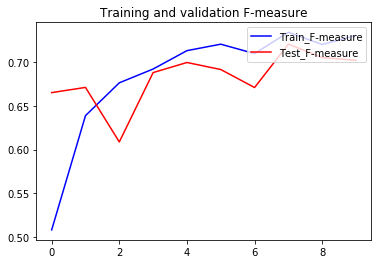

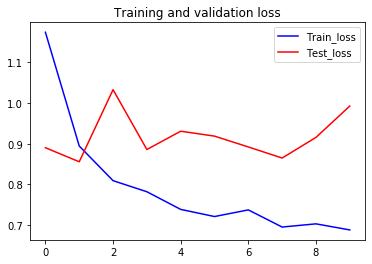

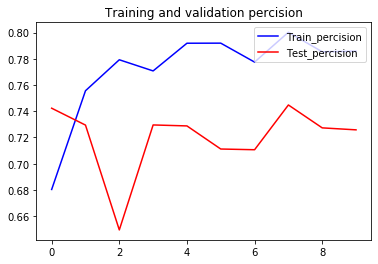

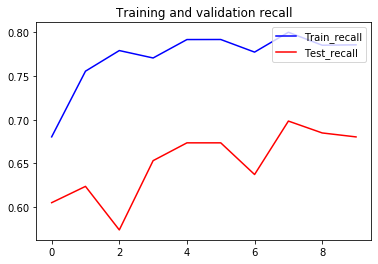

In [14]:
import matplotlib.pyplot as plt

def plot_training(history):
  f = history.history['f_m']
  percision = history.history['precision_m']
  recall = history.history['precision_m']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_f = history.history['val_f_m']
  val_percision = history.history['val_precision_m']
  val_recall = history.history['val_recall_m']
  epochs = range(len(f))
  
  plt.plot(epochs, f, 'b',label='Train_F-measure')
  plt.plot(epochs, val_f, 'r',label='Test_F-measure')
  plt.title('Training and validation F-measure')
  plt.legend(loc="upper right")

  
  plt.figure()
  plt.plot(epochs, loss, 'b',label='Train_loss')
  plt.plot(epochs, val_loss, 'r',label='Test_loss')
  plt.title('Training and validation loss')
  plt.legend(loc="upper right")  
  
  plt.figure()
  plt.plot(epochs, percision, 'b',label='Train_percision')
  plt.plot(epochs, val_percision, 'r',label="Test_percision")
  plt.title('Training and validation percision')  
  plt.legend(loc="upper right")

  plt.figure()
  plt.plot(epochs, recall, 'b',label='Train_recall')
  plt.plot(epochs, val_recall, 'r',label='Test_recall')
  plt.title('Training and validation recall')  
  plt.legend(loc="upper right")
  plt.show()
  
  
plot_training(history)

In [15]:
!pip install xlsxwriter 

     |████████████████████████████████| 143kB 4.8MB/s 


In [0]:
from keras.models import load_model
import numpy as np
import xlsxwriter
from keras.preprocessing import image
import glob
from keras import backend as K
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# defining custom metrics for loading the saved model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# loading the model
model = load_model('InceptionV3.h5',custom_objects={'f_m': f_m,'precision_m':precision_m,'recall_m':recall_m})

# Creating feature vectors from dataset
workbook = xlsxwriter.Workbook('features.xlsx')
worksheet = workbook.add_worksheet()
ids = []
features = []
categories = []
row = 0

for filename in glob.glob('/content/drive/My Drive/RS/classified_dataset/test/*'):
  filename2 = filename.replace('/content/drive/My Drive/RS/classified_dataset/test/','')
  for filename3 in glob.glob( str(filename) +'/*.jpg'): 
    img = image.load_img(filename3, target_size=(299, 299))
    x = image.img_to_array(img)
    x = x.reshape(1,299,299,3)
    preds = model.predict(x)
    preds = preds[0]
    id = filename3.replace('/content/drive/My Drive/RS/classified_dataset/test/'+str(filename2)+'/', '')
    id = id.replace('.jpg', '')
    ids.append(id)
    features.append(preds)
    categories.append(filename2)
    worksheet.write(row, 0, id)
    worksheet.write(row, 1, filename2)
    worksheet.write(row, 2, preds[0])
    worksheet.write(row, 3, preds[1])
    worksheet.write(row, 4, preds[2])
    worksheet.write(row, 5, preds[3])
    worksheet.write(row, 6, preds[4])
    worksheet.write(row, 7, preds[5])
    worksheet.write(row, 8, preds[6])
    print(id,preds,filename2)
    row +=1

workbook.close() 



In [0]:
from keras.models import load_model
import numpy as np
import xlsxwriter
from keras.preprocessing import image
import glob
from keras import backend as K
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# defining custom metrics for loading the saved model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# loading the model
model = load_model('InceptionV3.h5',custom_objects={'f_m': f_m,'precision_m':precision_m,'recall_m':recall_m})

# Creating feature vectors from dataset
workbook = xlsxwriter.Workbook('featuresTR.xlsx')
worksheet = workbook.add_worksheet()
ids = []
features = []
categories = []
row = 0

for filename in glob.glob('/content/drive/My Drive/RS/classified_dataset/train/*'):
  filename2 = filename.replace('/content/drive/My Drive/RS/classified_dataset/train/','')
  for filename3 in glob.glob( str(filename) +'/*.jpg'): 
    img = image.load_img(filename3, target_size=(299, 299))
    x = image.img_to_array(img)
    x = x.reshape(1,299,299,3)
    preds = model.predict(x)
    preds = preds[0]
    id = filename3.replace('/content/drive/My Drive/RS/classified_dataset/train/'+str(filename2)+'/', '')
    id = id.replace('.jpg', '')
    ids.append(id)
    features.append(preds)
    categories.append(filename2)
    worksheet.write(row, 0, id)
    worksheet.write(row, 1, filename2)
    worksheet.write(row, 2, preds[0])
    worksheet.write(row, 3, preds[1])
    worksheet.write(row, 4, preds[2])
    worksheet.write(row, 5, preds[3])
    worksheet.write(row, 6, preds[4])
    worksheet.write(row, 7, preds[5])
    worksheet.write(row, 8, preds[6])
    print(id,preds,filename2)
    row +=1

workbook.close() 